Some notes/thoughts about this backtesting repo:

#### Choices

There are many choices for libraries and packages to use for backtesting. Some of the words I've heard of and considered are zipline, backtrader, quantconnect, openbb.

Here is what I know about them

### Zipline

Zipline is an algorithmic trading simulator. It was built and maintained by Quantopian, but in 2020 they were acquired by Robinhood. Since then the codebase has not been actively maintained. It is still running on Python 3.6 and has issues when building. Some people have critiqued the codebase.

There are two new repos, one called zipline-trader (https://github.com/shlomikushchi/zipline-trader) and zipline-reloaded (https://github.com/stefan-jansen/zipline-reloaded). Zipline reloaded is a fork by Stefan Jansen who is the author of a *Machine Learning for Algorithmic Trading*. As of 2022, it seems both packages seem to be receiving interest. While this was popular in the past, it seems that now it its age is starting to show. From reading other people's blog posts, it seems as if there are a lot of problems that need solving. While the problems ccan be solved, it requires a lot of work from the individual.

Stefan also maintains *Pyfolio*, another repo that was maintained by Quantopian and used alongside Zipline before 2020. 

### Backtrader

Backtrader (https://www.backtrader.com/) is another free and open-source Python-native framework for backtesting, however it does not use pandas, numpy, scipy, and other standard libraries.

It connects to Interactive Brokers for live data and trading, and it comes with reusable analyzers.

### QuantConnect

https://www.quantconnect.com/pricing

This provider seems very good, but it's not free. Perhaps at a later time when I have more strategies I would explore this. For the sake of research though I'll stick with free.




### OpenBB SDK

Out of all the options I saw, I chose OpenBB SDK as it looks the most promising. First, it has a front end terminal that you can use, much like a bloomberg terminal, but it also has a package you can load in and write your own Python scripts from. It provides a toolbox to perform financial analysis on a variety of asset classes.

https://openbb.co/

The rest of this notebook will contain some short sample code snippets of what we can do with OpenBB SDK.

### 1. Plot some technical indicators (making use of ta lib as well)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# from talib import RSI, BBANDS, MACD

In [2]:
#Follow the instructions to get openbb working on your end, it can take some time
from openbb_terminal.sdk import openbb

In [3]:
openbb.__version__

'3.1.0'

In [8]:
from openbb_terminal.sdk import TerminalStyle
theme = TerminalStyle("light", "light", "light")

## grab data

data = (
    openbb
    .stocks
    .load("AAPL", start_date="2022-01-01")
    .rename(columns={"Adj Close": "close"})
)

Loading Daily data for AAPL with starting period 2022-01-03.

In [9]:
from talib import RSI, BBANDS, MACD

## Create technical indicators with talib
## Note that different indicators take in different values

# Create Bollinger Bands
up, mid, low = BBANDS(
    data.close, 
    timeperiod=21, 
    nbdevup=2, 
    nbdevdn=2, 
    matype=0
)

# Create RSI
rsi = RSI(data.close, timeperiod=14)

# Create MACD
macd, macdsignal, macdhist = MACD(
    data.close, 
    fastperiod=12, 
    slowperiod=26, 
    signalperiod=9
)

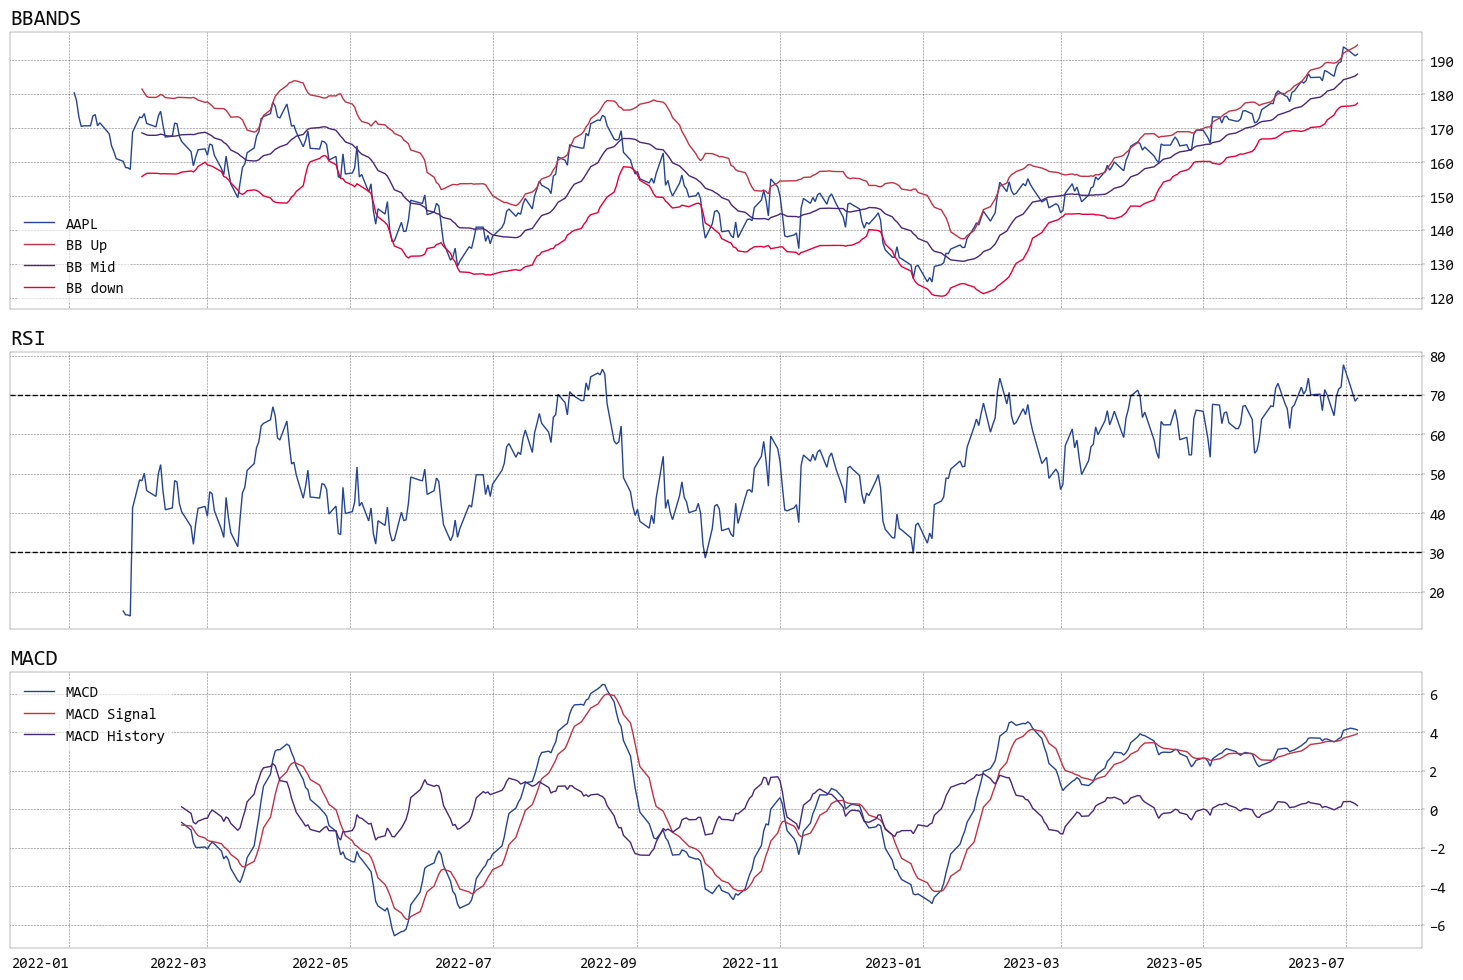

In [10]:
# Create DF for plotting 

macd = pd.DataFrame(
    {
        "MACD": macd,
        "MACD Signal": macdsignal,
        "MACD History": macdhist,
    }
)

data = pd.DataFrame(
    {
        "AAPL": data.close,
        "BB Up": up,
        "BB Mid": mid,
        "BB down": low,
        "RSI": rsi,
    }
)

## Plot

fig, axes = plt.subplots(
    nrows=3,
    figsize=(15, 10),
    sharex=True
)

data.drop(["RSI"], axis=1).plot(
    ax=axes[0],
    lw=1,
    title="BBANDS"
)
data["RSI"].plot(
    ax=axes[1],
    lw=1,
    title="RSI"
)
axes[1].axhline(70, lw=1, ls="--", c="k")
axes[1].axhline(30, lw=1, ls="--", c="k")
macd.plot(
    ax=axes[2],
    lw=1,
    title="MACD",
    rot=0
)
axes[2].set_xlabel("")
fig.tight_layout()

### 2. Compare two ETFs



In [14]:
openbb.etf.etf_by_name("MSCI World ETF")

,Symbol,Name
0,URTH,iShares MSCI World ETF


In [15]:
openbb.etf.etf_by_name("Vanguard FTSE All-World")

,Symbol,Name
0,VEU,Vanguard FTSE All-World ex-US ETF


In [16]:
holdings = openbb.etf.holdings("URTH")
holdings.head(7)

,Name,% Of Etf,Shares
Symbol,,,
AAPL,Apple Inc.,5.32%,750310
MSFT,Microsoft Corporation,4.20%,335351
AMZN,"Amazon.com, Inc.",2.12%,438095
NVDA,NVIDIA Corporation,1.84%,117225
TSLA,"Tesla, Inc.",1.41%,135108
GOOGL,Alphabet Inc.,1.28%,282929
GOOG,Alphabet Inc.,1.16%,254416


In [17]:
holdings = openbb.etf.holdings("VEU")
holdings.head(7)

,Name,% Of Etf,Shares
Symbol,,,
NESN.SW,Nestle SA,1.28%,5457633
N/A,SLCMT1142,1.24%,6248981
ASML.AS,ASML Holding NV,1.17%,815438
2330.TW,Taiwan Semiconductor Manufacturing Co Ltd,1.12%,31109873
005930.KS,Samsung Electronics Co Ltd,1.04%,9747259
NOVO B.CO,Novo Nordisk A/S Class B,1.01%,3164835
N/A,Us Dollar,0.96%,486010971


We see that the top 7 holdings in these two ETFs differ substantially.

Let's compare two more ETFs. The Total Market ETF against the SP 500 ETF, both from Vanguard.

In [19]:
# Additional comparisons:


compare_etfs = openbb.etf.compare(["VTI", "VOO"])
compare_etfs

,VTI,VOO
Assets,$307.15B,$314.47B
Expense Ratio,0.03%,0.03%
PE Ratio,18.80,19.80
Shares Out,1.39B,772.36M
Dividend (ttm),$3.34,$6.20
Dividend Yield,1.53%,1.54%
Ex-Dividend Date,"Jun 23, 2023","Jun 29, 2023"
Volume,"3,308,447","5,982,427"
Open,218.54,403.78
Previous Close,220.27,407.15
